In [11]:
%load_ext autoreload
%autoreload 2


import numpy as np
from Clasificador import Clasificador, ClasificadorRegresionLogistica, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.2,50)
cl = ClasificadorRegresionLogistica()

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  # A la matriz de entrenamiento la añadimos una columna de unos a la izquierda


Media:  0.17168141592920352
Varianza:  0.010772965776489937


In [ ]:
import numpy as np
from Clasificador import Clasificador, ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.8,20)
cl = ClasificadorVecinosProximos(5,distancia='euclidea',normaliza=False)

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

Media:  0.07659340659340659
Varianza:  7.886728655959425e-05


Pruebas scikit

In [ ]:
#kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5

distancias = ['euclidean','manhattan','mahalanobis']

data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

cov = np.cov(np.transpose(X))

for dist in distancias:
    if dist == 'mahalanobis':
        param = {'V': cov}
    else:
        param = None
    neigh = KNeighborsClassifier(n_neighbors=5, metric=dist, metric_params=param)
    err = 1 - cross_val_score(neigh,X,y,cv=numP)
    print('Distancia: ', dist)
    print('Error medio: ',np.mean(err),'\n')


Distancia:  euclidean
Error medio:  0.07205402887750349 

Distancia:  manhattan
Error medio:  0.06854525694767895 

Distancia:  mahalanobis
Error medio:  0.20034156186927493 



In [ ]:
# Regresión log
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5


clf = SGDClassifier(alpha=0.1)
data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

err = 1 - cross_val_score(clf,X,y,cv=numP)
print("Media: ",np.mean(err))

Media:  0.1264865704083217


Curvas ROC

Vecinos próximos (bien escrito)

In [1]:
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

def data_knn(distancias,vecinos,path,numEx=5,propTest=0.2,predNominal=True):
    header = ['Num. Vecinos'] + distancias

    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)

    datosTablaN = [vecinos,]
    datosTabla = [vecinos,]

    for dist in distancias:
        lstN = []
        lst = []
        for k in vecinos:
            # Normalizado
            clN = ClasificadorVecinosProximos(k,distancia=dist)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.mean(erroresN))
            lst.append(np.mean(errores))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [vecinos,]+list((np.array(datosTabla)-np.array(datosTablaN))[1:])
    return datosTablaN,datosTabla,diff

def print_knn(datosTablaN,datosTabla,diff):
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)

In [2]:
# WDBC
from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,'wdbc.data')

print_knn(datosTablaN,datosTabla,diff)

KeyboardInterrupt: 

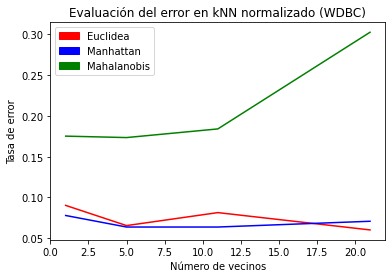

In [16]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (WDBC)')

plt.show()

In [24]:
# Diabetes
from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,'pima-indians-diabetes.data',predNominal=False)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

Sin normalizar:
Num. Vecinos      euclidea           manhattan          mahalanobis    
------------ ------------------ ------------------- -------------------
           1 0.3320261437908497 0.32941176470588235 0.32941176470588235
           5 0.2784313725490196  0.2627450980392157 0.26666666666666666
          11 0.2418300653594771 0.24575163398692806 0.24836601307189543
          21 0.2522875816993464 0.24444444444444446  0.2705882352941177


Normalizando:
Num. Vecinos       euclidea          manhattan          mahalanobis    
------------ ------------------- ------------------ -------------------
           1  0.3241830065359477 0.3176470588235294 0.30849673202614375
           5 0.29673202614379085 0.2954248366013072 0.28366013071895424
          11  0.2549019607843137 0.2627450980392157   0.257516339869281
          21 0.25098039215686274 0.2601307189542484   0.257516339869281


Diferencias:
Num. Vecinos        euclidea             manhattan            mahalanobis     
----------

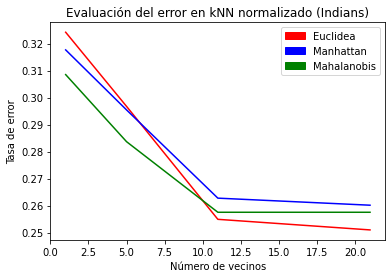

In [25]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (Indians)')

plt.show()

Regresión Logística

In [2]:
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

def data_log(constantes,pasos,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)

    datosTablaN = [constantes,]
    datosTabla = [constantes,]

    for paso in pasos:
        lstN = []
        lst = []
        for cte in constantes:
            # Normalizado
            clN = ClasificadorRegresionLogistica(eta=cte,epochs=paso)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorRegresionLogistica(eta=cte,epochs=paso,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.mean(erroresN))
            lst.append(np.mean(errores))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [constantes,]+list((np.array(datosTabla)-np.array(datosTablaN))[1:])
    return datosTablaN,datosTabla,diff
    

In [56]:
# WDBC
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

constantes = [0.01,0.1,1,5,10,20]
pasos = [1,10,50,100]

header = ['Cte \ Pasos'] + pasos

datosTablaN,datosTabla,diff = data_log(constantes,pasos,'wdbc.data')

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

/content/Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))


Sin normalizar:
Cte \ Pasos          1          ...          50                 100        
----------- ------------------- ... ------------------- -------------------
       0.01 0.39292035398230085 ... 0.10265486725663717 0.12920353982300886
        0.1 0.23716814159292038 ... 0.09557522123893805  0.1309734513274336
        1.0  0.3345132743362832 ... 0.11150442477876107 0.09557522123893805
        5.0  0.4212389380530973 ... 0.11858407079646019 0.15044247787610618
       10.0 0.20176991150442478 ... 0.12743362831858407  0.1592920353982301
       20.0 0.19292035398230092 ... 0.15575221238938053 0.08849557522123894


Normalizando:
Cte \ Pasos          1          ...          50                 100        
----------- ------------------- ... ------------------- -------------------
       0.01 0.35221238938053095 ... 0.13805309734513274 0.10088495575221237
        0.1  0.2814159292035398 ... 0.17345132743362832  0.1699115044247788
        1.0 0.11504424778761062 ...  0.1274336283185841 

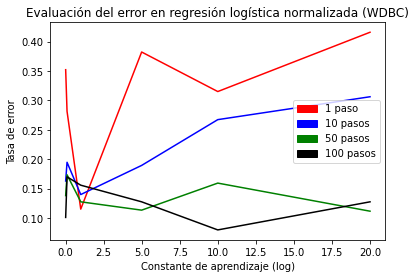

In [61]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

consts = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# 1 PASO
plt.plot(consts,datos[0],'r')
# 10 PASOS
plt.plot(consts,datos[1],'b')
# 50 PASOS
plt.plot(consts,datos[2],'g')
# 100 PASOS
plt.plot(consts,datos[3],'k')

red = mpatches.Patch(color='red', label='1 paso')
blue = mpatches.Patch(color='blue', label='10 pasos')
green = mpatches.Patch(color='green', label='50 pasos')
black = mpatches.Patch(color='black', label='100 pasos')

plt.legend(handles=[red,blue,green,black])
plt.xlabel('Constante de aprendizaje (log)')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en regresión logística normalizada (WDBC)')

plt.show()

In [3]:
# Indians
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

constantes = [0.01,0.1,1,5,10,20]
pasos = [1,10,50,100]

header = ['Cte \ Pasos'] + pasos

datosTablaN,datosTabla,diff = data_log(constantes,pasos,'pima-indians-diabetes.data',predNominal=False)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

TypeError: descriptor 'lower' for 'str' objects doesn't apply to a 'numpy.float64' object

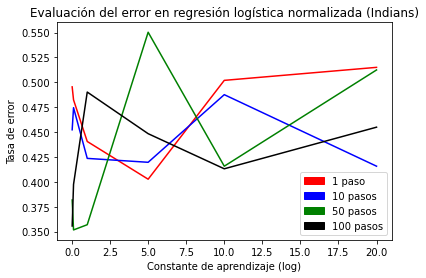

In [22]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

consts = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# 1 PASO
plt.plot(consts,datos[0],'r')
# 10 PASOS
plt.plot(consts,datos[1],'b')
# 50 PASOS
plt.plot(consts,datos[2],'g')
# 100 PASOS
plt.plot(consts,datos[3],'k')

red = mpatches.Patch(color='red', label='1 paso')
blue = mpatches.Patch(color='blue', label='10 pasos')
green = mpatches.Patch(color='green', label='50 pasos')
black = mpatches.Patch(color='black', label='100 pasos')

plt.legend(handles=[red,blue,green,black])
plt.xlabel('Constante de aprendizaje (log)')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en regresión logística normalizada (Indians)')

plt.show()

Scipy: kNN

In [8]:
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def compare_scipy_knn(distancia,vecinos,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []
    
    if distancia == 'euclidea':
        dist = 'euclidean'
    else:
        dist = distancia

    for vecino in vecinos:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            if distancia == 'mahalanobis':
                param = {V: np.cov(np.transpose(X_train))}
            else:
                param = None
            
            clf = KNeighborsClassifier(n_neighbors=vecino, metric=dist, metric_params=param)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorVecinosProximos(vecino,distancia=distancia)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
            
        
    return datosScipy, datosPropios

def plot_diff_knn(vecinos, datosScipy, datosPropios, title=None):
    plt.plot(vecinos,datosScipy,'r')
    plt.plot(vecinos,datosPropios, 'b')
    
    red = mpatches.Patch(color='red', label='Scipy')
    blue = mpatches.Patch(color='blue', label='Propio')
    
    plt.legend(handles=[red,blue])
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()

WDBC

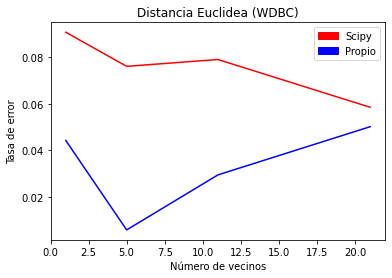

In [13]:
# Distancia euclidea
vecinos = [1,5,11,21]
datosScipy, datosPropios = compare_scipy_knn('euclidea',vecinos,'wdbc.data',numEx=3)

plot_diff_knn(vecinos, datosScipy, datosPropios, 'Distancia Euclidea (WDBC)')

Scipy: Regresión Logística

In [5]:
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def compare_scipy_reg(cte,epocas,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []

    for epoca in epocas:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            
            clf = SGDClassifier(learning_rate='constant',eta0=cte,tol=None,max_iter=epoca)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorRegresionLogistica(eta=cte,epochs=epoca)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
            
        
    return datosScipy, datosPropios

def plot_diff_reg(vecinos, datosScipy, datosPropios, title=None):
    plt.plot(vecinos,datosScipy,'r')
    plt.plot(vecinos,datosPropios, 'b')
    
    red = mpatches.Patch(color='red', label='Scipy')
    blue = mpatches.Patch(color='blue', label='Propio')
    
    plt.legend(handles=[red,blue])
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))
C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))
C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))
C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))


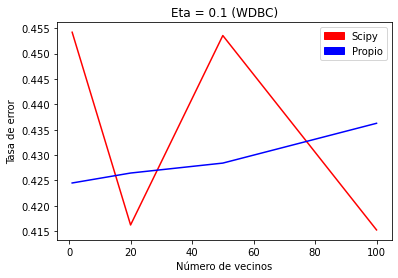

In [7]:
# eta = 0.1
epocas = [1,20,50,100]
datosScipy, datosPropios = compare_scipy_reg(0.1,epocas,'pima-indians-diabetes.data',numEx=20,predNominal=False)

plot_diff_reg(epocas, datosScipy, datosPropios, 'Eta = 0.1 (WDBC)')